In [1]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting

lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('Train_Final/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

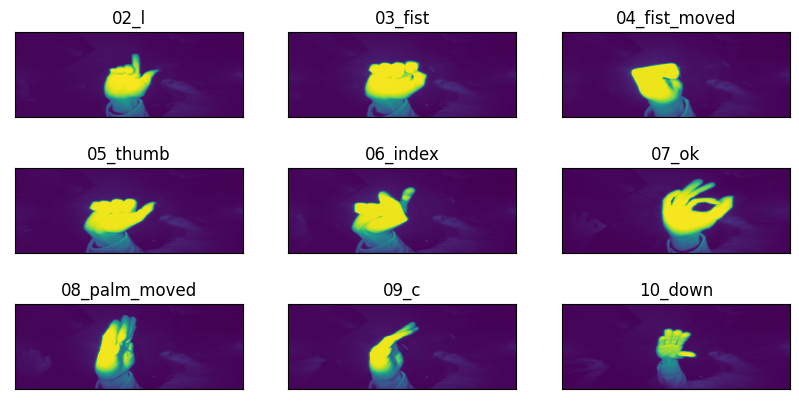

In [2]:
x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('Train_Final/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('Train_Final/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('Train_Final/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((320, 120))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

plt.figure(1, figsize=(10,5))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(x_data[i*200 , :, :])
    plt.xticks([])
    plt.yticks([])
    plt.title(reverselookup[y_data[i*200 ,0]])

In [3]:
# from random import randint
# for i in range(0, 10):
#     plt.imshow(x_data[i*200 , :, :])
#     plt.title(reverselookup[y_data[i*200 ,0]])
#     plt.show()


In [3]:
import keras
from keras.utils import to_categorical
y_data = to_categorical(y_data)

x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

In [13]:
from sklearn.model_selection import train_test_split
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.20)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)
x_train.shape, x_validate.shape, y_train.shape, y_validate.shape, x_test.shape, y_test.shape

((16000, 120, 320, 1),
 (2000, 120, 320, 1),
 (16000, 10),
 (2000, 10),
 (2000, 120, 320, 1),
 (2000, 10))

In [7]:
from keras import layers
from keras import models

model=models.Sequential()
#model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320,1))) 
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320,1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
#model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(8, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))

print("Train accuracy:", history.history['accuracy'][-1])
print("Val accuracy:", history.history['val_accuracy'][-1])

print("Train loss:", history.history['loss'][-1])
print("Val loss:", history.history['val_loss'][-1])

[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print('Test accuracy: {:2.2f}%'.format(acc*100))

Epoch 1/5
250/250 [==============================] - 18s 70ms/step - loss: 1.0543 - accuracy: 0.8207 - val_loss: 0.5136 - val_accuracy: 0.9705
Epoch 2/5
250/250 [==============================] - 18s 70ms/step - loss: 0.2908 - accuracy: 0.9893 - val_loss: 0.1432 - val_accuracy: 0.9945
Epoch 3/5
250/250 [==============================] - 18s 71ms/step - loss: 0.0815 - accuracy: 0.9958 - val_loss: 0.0399 - val_accuracy: 0.9975
Epoch 4/5
250/250 [==============================] - 18s 71ms/step - loss: 0.0253 - accuracy: 0.9979 - val_loss: 0.0175 - val_accuracy: 0.9980
Epoch 5/5
250/250 [==============================] - 18s 71ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.0158 - val_accuracy: 0.9975
Train accuracy: 0.9986875057220459
Val accuracy: 0.9975000023841858
Train loss: 0.010979164391756058
Val loss: 0.0157791581004858
63/63 [==============================] - 1s 10ms/step - loss: 0.0066 - accuracy: 0.9995
Test accuracy: 99.95%


In [8]:
# Predict labels for test data
y_pred = model.predict(x_test)

# Convert predicted labels to one-hot encoded format
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import precision_recall_fscore_support

# Assuming you have y_pred_classes and y_test_classes

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

63/63 [==============================] - 1s 9ms/step
Precision: 0.999502538071066
Recall: 0.9995
F1 Score: 0.9995000032209231


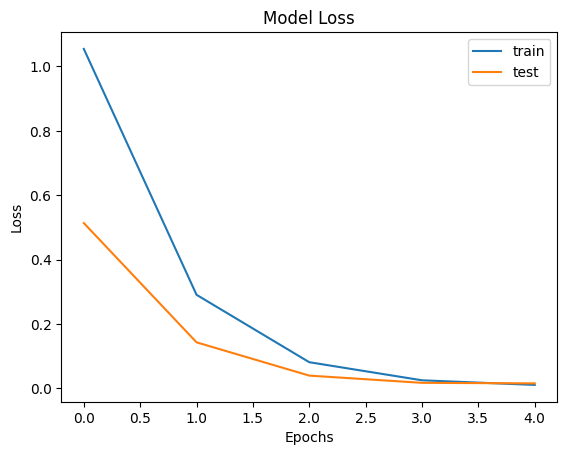

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

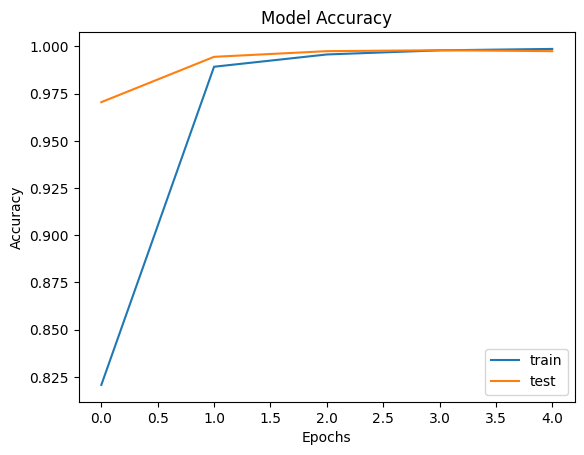

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

63/63 [==============================] - 1s 8ms/step


[]

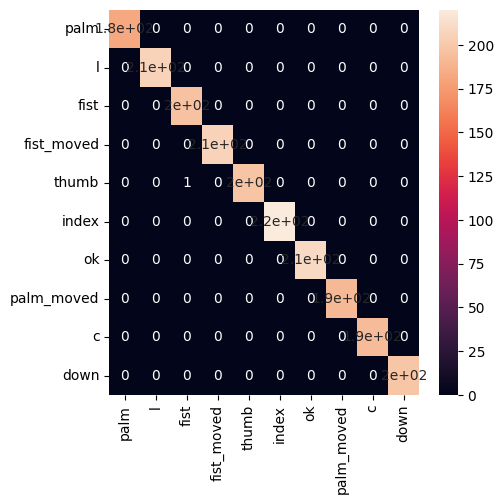

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c[3:] for c in lookup]
plt.figure(figsize=(5,5))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1))
sn.heatmap(cm, annot=True,xticklabels=cat, yticklabels=cat)
plt.plot()

AIX (SHAP)

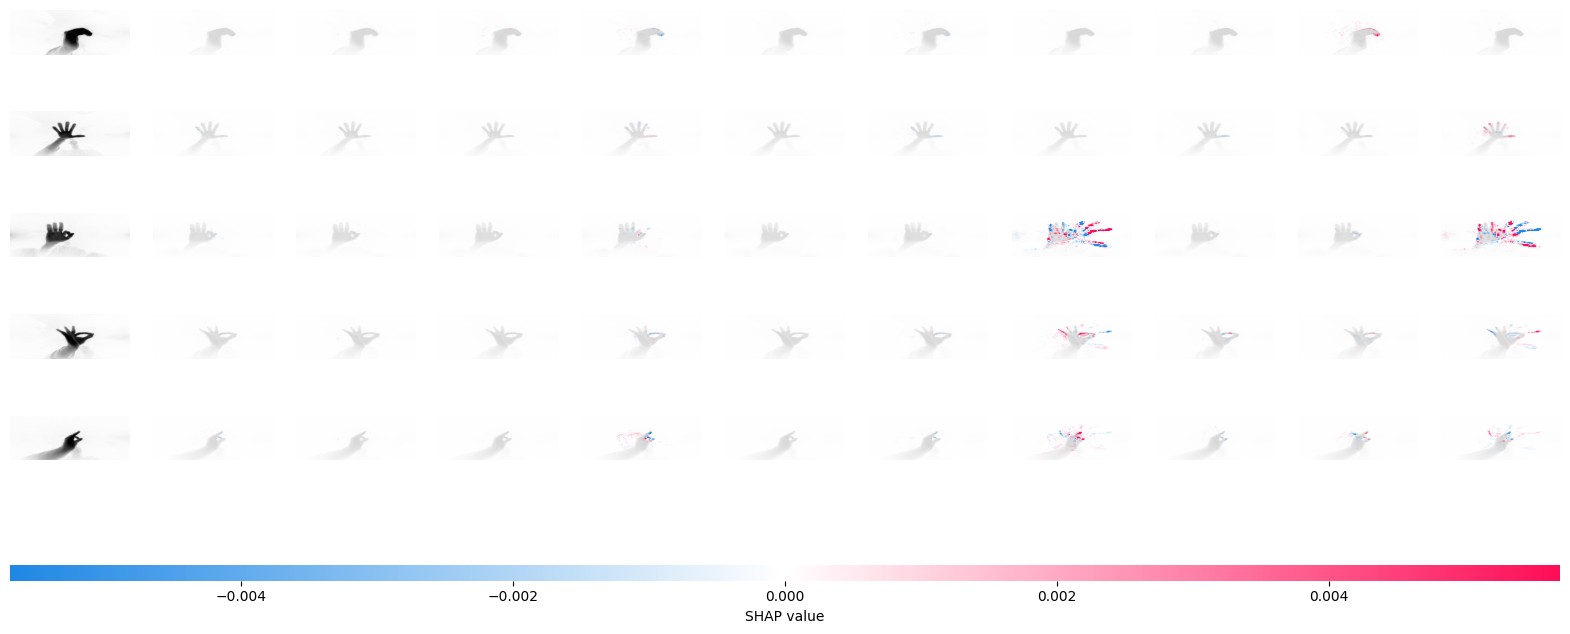

In [16]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 20, replace=False)]

# explain predictions of the model on ten images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:6])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:6])